In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
from matplotlib import pyplot as plt
from pns_dict import PNS_DICT
import seaborn as sns
import copy


PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_analysis').resolve()

def save_fig(fig_i, name):
    fig_i.savefig(PATH_GEN_DATA / '01_pns_{}.png'.format(name), bbox_inches='tight')
    fig_i.savefig(PATH_GEN_DATA / '01_pns_{}.pdf'.format(name), bbox_inches='tight')

# Como é a distribuição de sintomas depressivos por idade

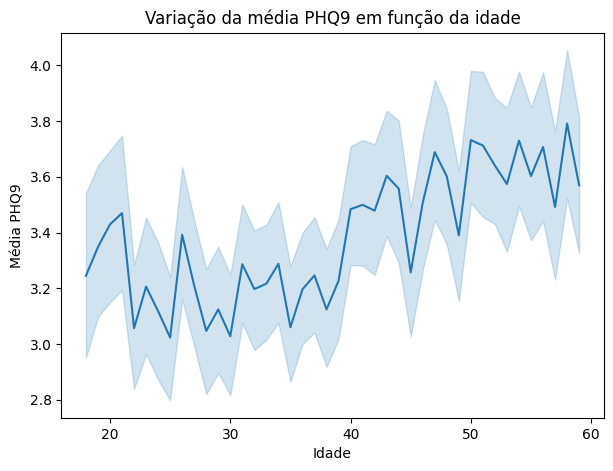

In [2]:
fig, ax = plt.subplots(figsize=(7, 5))

selected = df[['idade', 'phq9_total']]
selected = selected.dropna()
sns.lineplot(data=selected, x="idade", y="phq9_total")
ax.set_ylabel('Média PHQ9')
ax.set_xlabel('Idade')
ax.set_title("Variação da média PHQ9 em função da idade")
save_fig(fig, 'idade_phq9')

/tmp/ipykernel_24125/59345013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['idade'] = df['idade'].apply(categories)


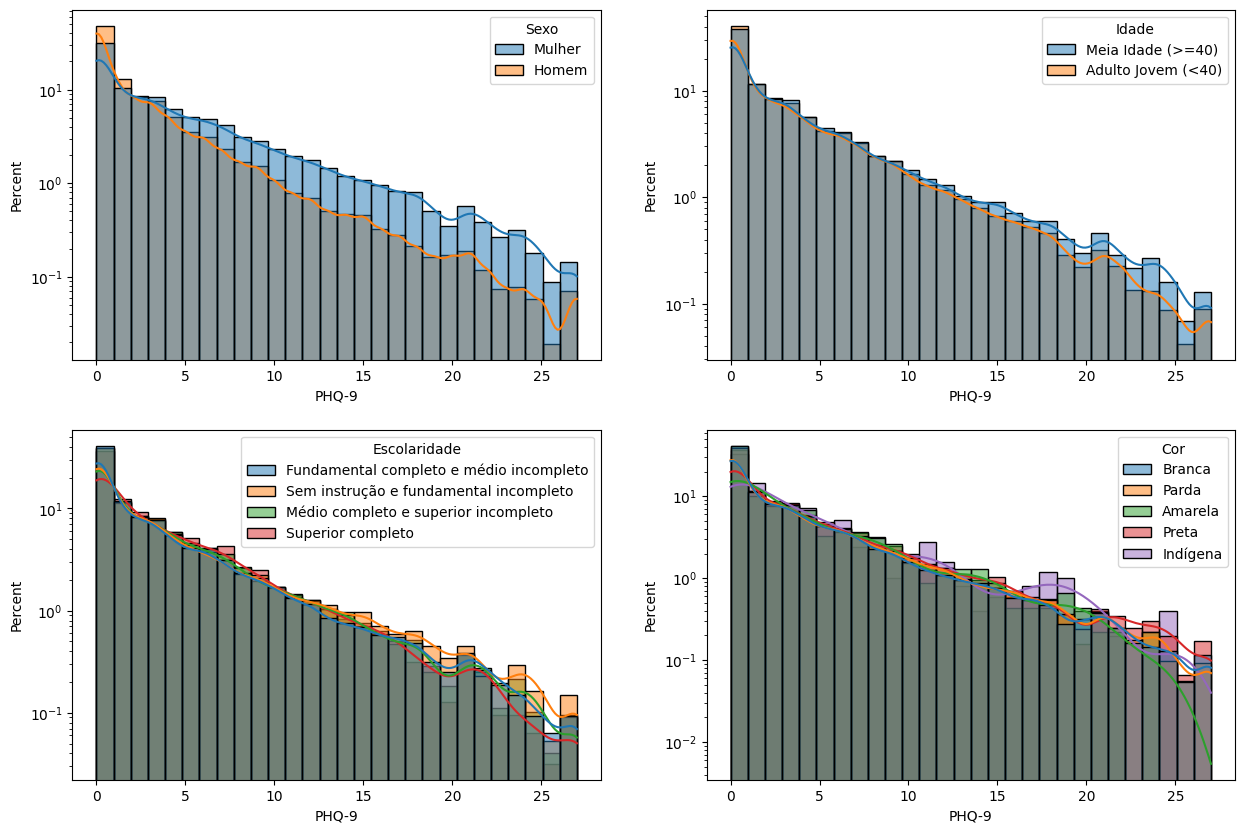

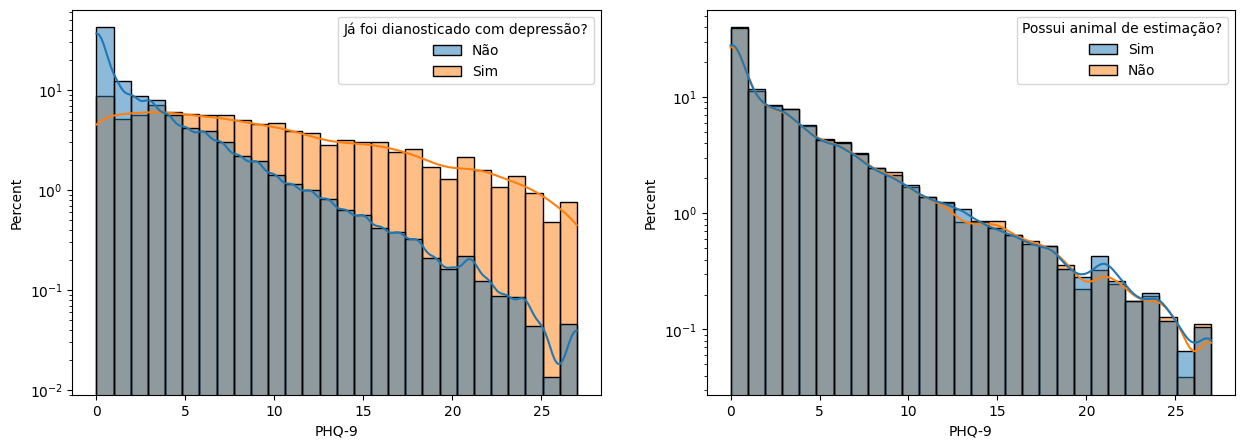

In [3]:
selected = df[['idade', 'sexo', 'cor', 'escolaridade_agregada',  'casa_animal',  'Q092', 'phq9_total']]

def categories(idade):
    if idade < 40:
        return 'Adulto Jovem (<40)'
    else:
        return 'Meia Idade (>=40)'

selected['idade'] = df['idade'].apply(categories)

def plot_dist_phq9(df_i, key, pv, tl, ax):
    df_i = copy.deepcopy(df_i)
    if pv is not None:
        df_i[tl] = df_i[key].map(pv)
    else:
        df_i[tl] = df_i[key]

    ax.set_yscale('log')
    sns.histplot(df_i, hue=tl, x='phq9_total', bins=28, kde=True, ax=ax, stat='percent', label='Sexo', cumulative=False, common_norm=False)
    ax.set_xlabel("PHQ-9")


fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_dist_phq9(selected, 'sexo', PNS_DICT.get_pv_dict('sexo'), 'Sexo', ax[0, 0])
plot_dist_phq9(selected, 'idade', None, 'Idade', ax[0, 1])
plot_dist_phq9(selected, 'escolaridade_agregada', PNS_DICT.get_pv_dict('escolaridade_agregada'), 'Escolaridade', ax[1, 0])
plot_dist_phq9(selected, 'cor', PNS_DICT.get_pv_dict('cor'), 'Cor', ax[1, 1])
plt.show()
save_fig(fig, 'compare_dist_phq9_startos1')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_dist_phq9(selected, 'Q092', PNS_DICT.get_pv_dict('Q092'), 'Já foi dianosticado com depressão?', ax[0])
plot_dist_phq9(selected, 'casa_animal', PNS_DICT.get_pv_dict('casa_animal'), 'Possui animal de estimação?', ax[1])
plt.show()
save_fig(fig, 'compare_dist_phq9_startos2')

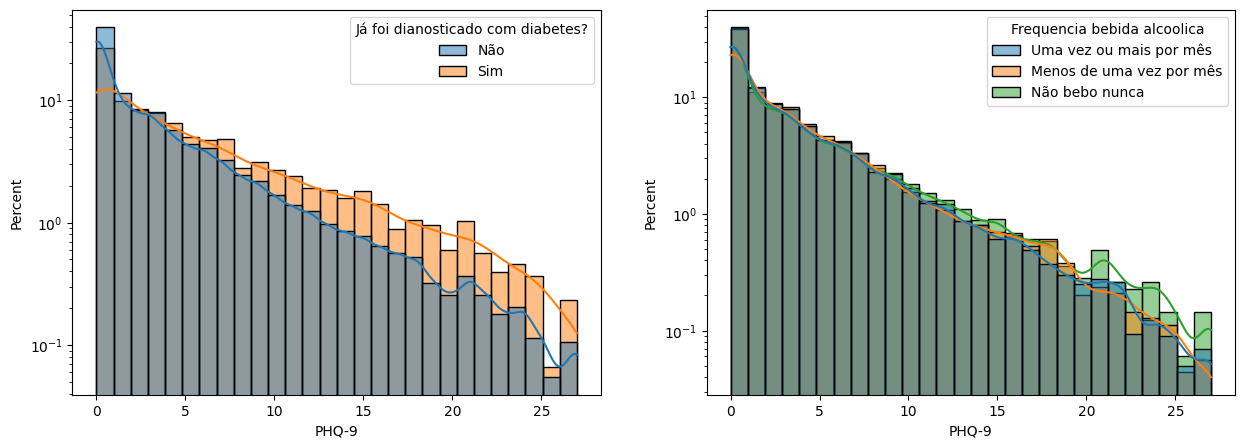

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_dist_phq9(df, 'Q03001', PNS_DICT.get_pv_dict('Q03001'), 'Já foi dianosticado com diabetes?', ax[0])
plot_dist_phq9(df, 'P027', PNS_DICT.get_pv_dict('P027'), "Frequencia bebida alcoolica", ax[1])

plt.show()

In [5]:
from IPython.core.display import Markdown
from scipy.stats import chi2_contingency

# Sugiro fazer associação segundo teste x² de Pearson
# Relações sobre caracteristicas da amostra:
# Nivel de escolaridade e renda per capita
# Raça-cor e renda per capita
# Percepção de saúde e nível de escolaridade
# Percepção de saúde segundo OMS e nível de escolaridade
# Percepção de saúde e raça-cor
# Percepção de saúde segundo OMS e raça-cor
#
# Relação sobre depressão e caracteristicas:
# Depressao e sexo
# Depressão e raça-cor
# Depressao e nivel de escolaridade
# Depressão e percepção de saúde
# Depressão e percepção de saúde segundo OMS
#
# Relação sobre depressão e hábitos:
# Depressão e consumo de bebidas alcoolicas
# AQUI FALTA COMPORTAMENTO ALIMENTAR E TABAGISMO
#
# Relação sobre depressão e doenças crônicas:
# Depressão e artrite
# Depressão e AVC
# Depressao e doenças cardiovasculares
# Depressao e hipertensao
# Depressao e diabetes
# Depressao e pressão alta - depois melhor colocar hipertensao
# Depressão e cancer

def gen_chi2_statistics(df_i, columns_dict, key_dep_d = 'depression_p'):

    selected_g = copy.deepcopy(df_i)
    selected_g['depression_p'] = selected_g['depression_severity'] > 3
    data = []

    for c in columns_dict:


        display(Markdown("### {}".format(c['name'])))

        selected = copy.deepcopy(selected_g)

        key_dep = key_dep_d
        if 'dep' in c:
            key_dep = c['dep']

        selected = selected.dropna(subset= [c['key'], key_dep])
        contingency_table = pd.crosstab(selected[c['key']], selected[key_dep])
        chi2, p_value, dof, _ = chi2_contingency(contingency_table, correction=False)


        # Para printar
        contingency_table = pd.crosstab(selected[c['key']], selected[key_dep], normalize=False)
        contingency_table_n = pd.crosstab(selected[c['key']], selected[key_dep], normalize=True)
        try:
            contingency_table.index = contingency_table.index.map(PNS_DICT.get_pv_dict(c['key']))
            contingency_table_n.index = contingency_table_n.index.map(PNS_DICT.get_pv_dict(c['key']))
        except:
            pass
        try:
            contingency_table.columns = contingency_table.columns.map(PNS_DICT.get_pv_dict(key_dep))
            contingency_table_n.columns = contingency_table_n.columns.map(PNS_DICT.get_pv_dict(key_dep))
        except:
            pass

        display(contingency_table)
        display(contingency_table_n*100)

        print("chi2: {}, p_value: {}, dof: {}".format(chi2, p_value, dof))

        print("-------------------------------------------------------------")
        print()

        data.append([c['key'], key_dep, c['name'], chi2, p_value, dof])

    return pd.DataFrame(data, columns=['variavel1', 'variavel2', 'titulo', 'chi2', 'p_value', 'dof'])

selected_columns = [
    # Gerais
    {'key': 'escolaridade_agregada', 'dep': 'renda_pc', 'name': 'Nivel de escolaridade e renda per capita'},
    {'key': 'cor', 'dep': 'renda_pc', 'name': 'Raça-cor e renda per capita'},
    {'key': 'N001', 'dep': 'escolaridade_agregada', 'name': 'Percepção de saúde e nível de escolaridade'},
    {'key': 'N00101', 'dep': 'escolaridade_agregada', 'name': 'Percepção de saúde segundo OMS e nível de escolaridade'},
    {'key': 'N001', 'dep': 'cor', 'name': 'Percepção de saúde e raça-cor'},
    {'key': 'N00101', 'dep': 'cor', 'name': 'Percepção de saúde segundo OMS e raça-cor'},

    # Gerais depressão
    {'key': 'sexo', 'name': 'Sexo'},
    {'key': 'cor', 'name': 'Cor'},
    {'key': 'escolaridade_agregada', 'name': 'Escolaridade'},
    {'key': 'N001', 'name': 'Percepção da própria saúde'},
    {'key': 'N00101', 'name': 'Percepção da saúde segundo a OMS'},
    {'key': 'casa_animal', 'name': 'Possui animal de estimação?'},
    {'key': 'renda_pc', 'name': 'Renda per capita'},


    {'key': 'P027', 'name': 'Frequência bebida alcoólica'},
    {'key': 'P050', 'name': 'Fuma tabaco'},
    {'key': 'P034', 'name': 'Atividade fisica nos ultimos 3 meses'},


    # Doenças cronicas
    {'key': 'Q079', 'name': 'Teve diganostico artrite ou reumatismo'},
    {'key': 'Q068', 'name': 'Teve diganostico AVC'},
    {'key': 'Q06306', 'name': 'Teve diganostico doenças cardiovasculares'},
    {'key': 'Q060', 'name': 'Teve diganostico hipercolesterolemia'},
    {'key': 'Q03001', 'name': 'Teve diganostico diabetes'},
    {'key': 'Q00201', 'name': 'Teve diganostico pressão alta'},
    {'key': 'Q120', 'name': 'Teve diganostico cancer'},
]

df_chi = gen_chi2_statistics(df, selected_columns)
df_chi

### Nivel de escolaridade e renda per capita

renda_pc,Até ¼ salário mínimo,Mais de ¼ até ½ salário mínimo,Mais de ½ até 1 salário mínimo,Mais de 1 até 2 salários mínimos,Mais de 2 até 3 salários mínimos,Mais de 3 até 5 salários mínimos,Mais de 5 salários mínimos
escolaridade_agregada,,,,,,,
Sem instrução e fundamental incompleto,4854,6225,10844,7394,1624,702,239
Fundamental completo e médio incompleto,2596,4732,8494,7690,2226,1261,614
Médio completo e superior incompleto,393,718,2167,3571,2092,2005,2123
Superior completo,29,48,182,635,631,837,1516


renda_pc,Até ¼ salário mínimo,Mais de ¼ até ½ salário mínimo,Mais de ½ até 1 salário mínimo,Mais de 1 até 2 salários mínimos,Mais de 2 até 3 salários mínimos,Mais de 3 até 5 salários mínimos,Mais de 5 salários mínimos
escolaridade_agregada,,,,,,,
Sem instrução e fundamental incompleto,6.349912,8.143429,14.185919,9.672693,2.124487,0.918343,0.312655
Fundamental completo e médio incompleto,3.396039,6.190314,11.111693,10.059915,2.912012,1.649617,0.803223
Médio completo e superior incompleto,0.514115,0.939274,2.834829,4.671516,2.736715,2.622904,2.777269
Superior completo,0.037937,0.062793,0.238089,0.830695,0.825462,1.094948,1.983203


chi2: 23047.025547068377, p_value: 0.0, dof: 18
-------------------------------------------------------------



### Raça-cor e renda per capita

renda_pc,Até ¼ salário mínimo,Mais de ¼ até ½ salário mínimo,Mais de ½ até 1 salário mínimo,Mais de 1 até 2 salários mínimos,Mais de 2 até 3 salários mínimos,Mais de 3 até 5 salários mínimos,Mais de 5 salários mínimos
cor,,,,,,,
Branca,1911,3257,7918,9155,3949,3259,3512
Preta,1205,1790,3368,2533,718,414,245
Amarela,48,74,156,168,78,68,85
Parda,6228,8815,14605,10346,2779,1756,1226
Indígena,109,132,220,146,41,23,11


renda_pc,Até ¼ salário mínimo,Mais de ¼ até ½ salário mínimo,Mais de ½ até 1 salário mínimo,Mais de 1 até 2 salários mínimos,Mais de 2 até 3 salários mínimos,Mais de 3 até 5 salários mínimos,Mais de 5 salários mínimos
cor,,,,,,,
Branca,2.115155,3.604950,8.763891,10.133041,4.370877,3.607163,3.887192
Preta,1.333732,1.981228,3.727808,2.803604,0.794705,0.458228,0.271174
Amarela,0.053128,0.081906,0.172666,0.185948,0.086333,0.075265,0.094081
Parda,6.893346,9.756718,16.165272,11.451277,3.075884,1.943596,1.356975
Indígena,0.120645,0.146102,0.243503,0.161597,0.045380,0.025457,0.012175


chi2: 7517.540990849386, p_value: 0.0, dof: 24
-------------------------------------------------------------



### Percepção de saúde e nível de escolaridade

escolaridade_agregada,Sem instrução e fundamental incompleto,Fundamental completo e médio incompleto,Médio completo e superior incompleto,Superior completo
N001,,,,
Muito boa,2127,3871,2781,1122
Boa,13640,14926,7191,2143
Regular,12795,7695,2728,548
Ruim,2683,925,296,58
Muito ruim,644,206,74,7


escolaridade_agregada,Sem instrução e fundamental incompleto,Fundamental completo e médio incompleto,Médio completo e superior incompleto,Superior completo
N001,,,,
Muito boa,2.781847,5.062778,3.637196,1.467434
Boa,17.839393,19.521318,9.404918,2.802773
Regular,16.734240,10.064086,3.567879,0.716715
Ruim,3.509024,1.209783,0.387131,0.075857
Muito ruim,0.842270,0.269422,0.096783,0.009155


chi2: 6137.038260521892, p_value: 0.0, dof: 12
-------------------------------------------------------------



### Percepção de saúde segundo OMS e nível de escolaridade

escolaridade_agregada,Sem instrução e fundamental incompleto,Fundamental completo e médio incompleto,Médio completo e superior incompleto,Superior completo
N00101,,,,
Muito boa,2795,4624,3105,1219
Boa,17982,16873,7699,2154
Regular,9079,5304,1966,455
Ruim,1665,679,245,46
Muito ruim,368,143,55,4


escolaridade_agregada,Sem instrução e fundamental incompleto,Fundamental completo e médio incompleto,Médio completo e superior incompleto,Superior completo
N00101,,,,
Muito boa,3.655506,6.047607,4.060947,1.594298
Boa,23.518179,22.067748,10.069317,2.817159
Regular,11.874183,6.936961,2.571279,0.595082
Ruim,2.177609,0.888046,0.320429,0.060162
Muito ruim,0.481297,0.187026,0.071933,0.005231


chi2: 4083.091991570913, p_value: 0.0, dof: 12
-------------------------------------------------------------



### Percepção de saúde e raça-cor

cor,Branca,Preta,Amarela,Parda,Indígena
N001,,,,,
Muito boa,5595,1162,112,4973,72
Boa,16766,4883,338,22309,319
Regular,8790,3406,193,15149,229
Ruim,1459,672,28,2699,50
Muito ruim,359,155,6,634,12


cor,Branca,Preta,Amarela,Parda,Indígena
N001,,,,,
Muito boa,6.191214,1.285825,0.123935,5.502932,0.079672
Boa,18.552617,5.403342,0.374018,24.686290,0.352993
Regular,9.726679,3.768950,0.213566,16.763306,0.253403
Ruim,1.614474,0.743610,0.030984,2.986611,0.055328
Muito ruim,0.397256,0.171517,0.006639,0.701560,0.013279


chi2: 1020.9872814531317, p_value: 3.58851699178534e-207, dof: 16
-------------------------------------------------------------



### Percepção de saúde segundo OMS e raça-cor

cor,Branca,Preta,Amarela,Parda,Indígena
N00101,,,,,
Muito boa,6275,1432,128,5962,99
Boa,18956,5922,393,26758,375
Regular,6431,2386,134,10881,171
Ruim,1090,421,16,1794,32
Muito ruim,217,117,6,369,5


cor,Branca,Preta,Amarela,Parda,Indígena
N00101,,,,,
Muito boa,6.943676,1.584597,0.141640,6.597322,0.109550
Boa,20.975988,6.553060,0.434879,29.609384,0.414961
Regular,7.116300,2.640257,0.148279,12.040500,0.189222
Ruim,1.206152,0.465863,0.017705,1.985172,0.035410
Muito ruim,0.240124,0.129468,0.006639,0.408321,0.005533


chi2: 695.9424696839698, p_value: 9.444638295739669e-138, dof: 16
-------------------------------------------------------------



### Sexo

depression_p,False,True
sexo,,
Homem,41823,690
Mulher,45647,2210


depression_p,False,True
sexo,,
Homem,46.279739,0.763528
Mulher,50.511232,2.445502


chi2: 650.1244558930703, p_value: 2.0991548153970957e-143, dof: 1
-------------------------------------------------------------



### Cor

depression_p,False,True
cor,,
Branca,32026,943
Preta,9892,386
Amarela,659,18
Parda,44239,1525
Indígena,654,28


depression_p,False,True
cor,,
Branca,35.438752,1.043488
Preta,10.946110,0.427133
Amarela,0.729224,0.019918
Parda,48.953192,1.687507
Indígena,0.723691,0.030984


chi2: 27.460576859111317, p_value: 1.6040679105467477e-05, dof: 4
-------------------------------------------------------------



### Escolaridade

depression_p,False,True
escolaridade_agregada,,
Sem instrução e fundamental incompleto,30800,1089
Fundamental completo e médio incompleto,26663,960
Médio completo e superior incompleto,12683,387
Superior completo,3763,115


depression_p,False,True
escolaridade_agregada,,
Sem instrução e fundamental incompleto,40.282501,1.424274
Fundamental completo e médio incompleto,34.871828,1.255558
Médio completo e superior incompleto,16.587758,0.506147
Superior completo,4.921528,0.150405


chi2: 9.630887117105123, p_value: 0.02197894444717136, dof: 3
-------------------------------------------------------------



### Percepção da própria saúde

depression_p,False,True
N001,,
Muito boa,11795,119
Boa,43923,692
Regular,26492,1275
Ruim,4331,577
Muito ruim,929,237


depression_p,False,True
N001,,
Muito boa,13.051898,0.131681
Boa,48.603519,0.765741
Regular,29.315038,1.410866
Ruim,4.792520,0.638486
Muito ruim,1.027996,0.262255


chi2: 3007.405389314013, p_value: 0.0, dof: 4
-------------------------------------------------------------



### Percepção da saúde segundo a OMS

depression_p,False,True
N00101,,
Muito boa,13788,108
Boa,51576,828
Regular,18827,1176
Ruim,2759,594
Muito ruim,520,194


depression_p,False,True
N00101,,
Muito boa,15.257276,0.119509
Boa,57.072037,0.916233
Regular,20.833241,1.301317
Ruim,3.053004,0.657298
Muito ruim,0.575412,0.214673


chi2: 4762.962736471147, p_value: 0.0, dof: 4
-------------------------------------------------------------



### Possui animal de estimação?

depression_p,False,True
casa_animal,,
Sim,51859,1763
Não,35611,1137


depression_p,False,True
casa_animal,,
Sim,57.385194,1.950869
Não,39.405776,1.258161


chi2: 2.636199700748006, p_value: 0.1044531334019662, dof: 1
-------------------------------------------------------------



### Renda per capita

depression_p,False,True
renda_pc,,
Até ¼ salário mínimo,9020,481
Mais de ¼ até ½ salário mínimo,13478,590
Mais de ½ até 1 salário mínimo,25394,873
Mais de 1 até 2 salários mínimos,21761,587
Mais de 2 até 3 salários mínimos,7379,186
Mais de 3 até 5 salários mínimos,5422,98
Mais de 5 salários mínimos,4994,85


depression_p,False,True
renda_pc,,
Até ¼ salário mínimo,9.983619,0.532386
Mais de ¼ até ½ salário mínimo,14.917873,0.653031
Mais de ½ até 1 salário mínimo,28.106876,0.966264
Mais de 1 até 2 salários mínimos,24.085757,0.649710
Mais de 2 até 3 salários mínimos,8.167309,0.205871
Mais de 3 até 5 salários mínimos,6.001240,0.108469
Mais de 5 salários mínimos,5.527516,0.094081


chi2: 263.2751810852181, p_value: 5.954547362228496e-54, dof: 6
-------------------------------------------------------------



### Frequência bebida alcoólica

depression_p,False,True
P027,,
Não bebo nunca,53389,1801
Menos de uma vez por mês,10673,362
Uma vez ou mais por mês,23408,737


depression_p,False,True
P027,,
Não bebo nunca,59.078234,1.992918
Menos de uma vez por mês,11.810335,0.400575
Uma vez ou mais por mês,25.902401,0.815536


chi2: 2.611396249192711, p_value: 0.27098328889541073, dof: 2
-------------------------------------------------------------



### Fuma tabaco

depression_p,False,True
P050,,
"Sim, diariamente",9660,487
"Sim, menos que diariamente",1126,53
Não fumo atualmente,76684,2360


depression_p,False,True
P050,,
"Sim, diariamente",10.689388,0.538896
"Sim, menos que diariamente",1.245989,0.058648
Não fumo atualmente,84.855594,2.611486


chi2: 101.60826014395812, p_value: 8.630712537649896e-23, dof: 2
-------------------------------------------------------------



### Atividade fisica nos ultimos 3 meses

depression_p,False,True
P034,,
Sim,35316,895
Não,52154,2005


depression_p,False,True
P034,,
Sim,39.07934,0.990373
Não,57.71163,2.218657


chi2: 105.77855819930565, p_value: 8.245296391605715e-25, dof: 1
-------------------------------------------------------------



### Teve diganostico artrite ou reumatismo

depression_p,False,True
Q079,,
Sim,6764,425
Não,80706,2475


depression_p,False,True
Q079,,
Sim,7.484785,0.470289
Não,89.306186,2.738741


chi2: 183.68830842232757, p_value: 7.588518198462411e-42, dof: 1
-------------------------------------------------------------



### Teve diganostico AVC

depression_p,False,True
Q068,,
Sim,1851,118
Não,85619,2782


depression_p,False,True
Q068,,
Sim,2.048246,0.130574
Não,94.742724,3.078455


chi2: 50.22259158454231, p_value: 1.3725848344604343e-12, dof: 1
-------------------------------------------------------------



### Teve diganostico doenças cardiovasculares

depression_p,False,True
Q06306,,
Sim,4420,296
Não,83050,2604


depression_p,False,True
Q06306,,
Sim,4.891004,0.327542
Não,91.899967,2.881487


chi2: 150.73156475517936, p_value: 1.199663915461858e-34, dof: 1
-------------------------------------------------------------



### Teve diganostico hipercolesterolemia

depression_p,False,True
Q060,,
Sim,12743,662
Não,66995,2075


depression_p,False,True
Q060,,
Sim,15.450743,0.802667
Não,81.230676,2.515914


chi2: 130.90821150013366, p_value: 2.593242991288927e-30, dof: 1
-------------------------------------------------------------



### Teve diganostico diabetes

depression_p,False,True
Q03001,,
Sim,7046,298
Não,73828,2481


depression_p,False,True
Q03001,,
Sim,8.422890,0.356233
Não,88.255054,2.965823


chi2: 13.566851729065355, p_value: 0.0002302151878881775, dof: 1
-------------------------------------------------------------



### Teve diganostico pressão alta

depression_p,False,True
Q00201,,
Sim,22823,911
Não,62584,1958


depression_p,False,True
Q00201,,
Sim,25.854139,1.031991
Não,70.895827,2.218043


chi2: 35.73478516590861, p_value: 2.260908025676986e-09, dof: 1
-------------------------------------------------------------



### Teve diganostico cancer

depression_p,False,True
Q120,,
Sim,2209,93
Não,85261,2807


depression_p,False,True
Q120,,
Sim,2.444395,0.102910
Não,94.346575,3.106119


chi2: 5.250948355941688, p_value: 0.021934813068023893, dof: 1
-------------------------------------------------------------



,variavel1,variavel2,titulo,chi2,p_value,dof
0,escolaridade_agregada,renda_pc,Nivel de escolaridade e renda per capita,23047.025547,0.000000e+00,18
1,cor,renda_pc,Raça-cor e renda per capita,7517.540991,0.000000e+00,24
2,N001,escolaridade_agregada,Percepção de saúde e nível de escolaridade,6137.038261,0.000000e+00,12
3,N00101,escolaridade_agregada,Percepção de saúde segundo OMS e nível de esco...,4083.091992,0.000000e+00,12
4,N001,cor,Percepção de saúde e raça-cor,1020.987281,3.588517e-207,16
5,N00101,cor,Percepção de saúde segundo OMS e raça-cor,695.942470,9.444638e-138,16
6,sexo,depression_p,Sexo,650.124456,2.099155e-143,1
7,cor,depression_p,Cor,27.460577,1.604068e-05,4
8,escolaridade_agregada,depression_p,Escolaridade,9.630887,2.197894e-02,3
9,N001,depression_p,Percepção da própria saúde,3007.405389,0.000000e+00,4
